In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D, Activation


In [2]:
BATCH_SIZE = 64
EPOCHS = 5
SIZE= 64
N_ch= 3
input_shape = (64, 64, 3)
chanDim = -1
IMAGE_SIZE = 64

# Loading the dataset

In [3]:
data = pd.read_csv('plant_disease.csv') 
data = data.drop('Unnamed: 0', axis = 1)
disease_types = ['Pepper__bell___Bacterial_spot','Pepper__bell___healthy','Potato___Early_blight','Potato___Late_blight','Potato___healthy','Tomato_Bacterial_spot','Tomato_Early_blight','Tomato_Late_blight','Tomato_Leaf_Mold','Tomato_Septoria_leaf_spot','Tomato_Spider_mites_Two_spotted_spider_mite','Tomato__Target_Spot','Tomato__Tomato_YellowLeaf__Curl_Virus','Tomato__Tomato_mosaic_virus','Tomato_healthy']
data_dir = 'PlantVillage/'
data.head()

,File,DiseaseID,Disease Type
0,Pepper__bell___Bacterial_spot/0022d6b7-d47c-4e...,0,Pepper__bell___Bacterial_spot
1,Pepper__bell___Bacterial_spot/006adb74-934f-44...,0,Pepper__bell___Bacterial_spot
2,Pepper__bell___Bacterial_spot/00f2e69a-1e56-41...,0,Pepper__bell___Bacterial_spot
3,Pepper__bell___Bacterial_spot/01613cd0-d3cd-4e...,0,Pepper__bell___Bacterial_spot
4,Pepper__bell___Bacterial_spot/0169b9ac-07b9-4b...,0,Pepper__bell___Bacterial_spot


# Randomizing the dataset

In [4]:
R_S = np.random.randint(0, 100)
data = data.sample( frac = 1, random_state = R_S)
data.index = np.arange(len(data)) # Reset indices
data.head(15)

,File,DiseaseID,Disease Type
0,Tomato__Target_Spot/87489e27-68d4-476b-810e-c1...,11,Tomato__Target_Spot
1,Tomato_Leaf_Mold/7f3398ef-a359-4ec4-b295-998c2...,8,Tomato_Leaf_Mold
2,Tomato_healthy/fd061d12-644d-4ac5-a0b5-2e88469...,14,Tomato_healthy
3,Tomato_healthy/221b0575-215a-430d-a728-60020b7...,14,Tomato_healthy
4,Tomato__Target_Spot/0fe6221c-5848-4000-afc6-5a...,11,Tomato__Target_Spot
5,Tomato_Spider_mites_Two_spotted_spider_mite/5a...,10,Tomato_Spider_mites_Two_spotted_spider_mite
6,Tomato__Tomato_YellowLeaf__Curl_Virus/00a538f3...,12,Tomato__Tomato_YellowLeaf__Curl_Virus
7,Potato___Early_blight/ed270d5d-3523-4bc2-b208-...,2,Potato___Early_blight
8,Tomato_healthy/cbd86fc5-7f88-4984-a1ed-445de8b...,14,Tomato_healthy
9,Tomato_Late_blight/98586693-fe1f-4ea0-8e27-450...,7,Tomato_Late_blight


# Loading the images from the image folder

In [5]:
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [6]:
Images = np.zeros((data.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(data['File'].values)):
    image = read_image(file)
    if image is not None:
        Images[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
Images = Images / 255.
print('Array Shape: {}'.format(Images.shape))

20639it [01:06, 308.90it/s]


Array Shape: (20639, 64, 64, 3)


# Creating unique lables for Y

In [7]:
Y = data['DiseaseID'].values
Y = to_categorical(Y, num_classes=15)


In [8]:
X_train, X_val, Y_train, Y_val = train_test_split(Images, Y, test_size=0.2, random_state=10)

# Defining the Model architecture

In [9]:
model = Sequential()
model.add(ResNet152V2(include_top = False, pooling = MaxPool2D,input_shape= input_shape, weights = 'imagenet'))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(502, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(15, activation = 'softmax'))

In [10]:
model.summary()
optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer = optimizer, metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 2, 2, 2048)        58331648  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8192)              32768     
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 502)               4112886   
_________________________________________________________________
batch_normalization_1 (Batch (None, 502)               2008      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               6

# Code I used to train the model
#### For ease I am loading the weights

# Model Information:
### Model was trained for 50 epochs on Kaggle Notebook
### Model's 1st layer is ResNet-152 and the weights were downloaded from the official keras website.
### I removed the top layers and replaced them with a combination of dense layers with batch Normalization and Dropouts. 
### The default optimizer used is adam and I experimented a bit with the values of the hyperparameters.
### This is the fourth model I trained and was the best in terms of accuracy.
### The other models include resnet-50v2, stacking conv layers, and ResNet-101. 
### Improvements needed:
### Increasing the image size for higher resolution. Image size greater than (64,64) overloads the RAM.
### Solution: Load data set in batches.

In [11]:
# annealer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
# checkpoint = tf.keras.callbacks.ModelCheckpoint('full_Train2.h5', verbose=1, save_best_only=True)

# datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=360, width_shift_range=0.2, height_shift_range=0.2, 
#                         zoom_range=0.2, horizontal_flip=True, vertical_flip=True) 

# datagen.fit(X_train)

# history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
#                steps_per_epoch=X_train.shape[0] // BATCH_SIZE, epochs=EPOCHS,verbose=1, callbacks=[annealer, checkpoint],
#                validation_data=(X_val, Y_val))

# Loading the Model

In [12]:
Model = tf.keras.models.load_model('fullTrain.h5')
Scores = Model.evaluate(X_val,Y_val)

129/129 [==============================] - 68s 528ms/step - loss: 0.1070 - accuracy: 0.9666


In [13]:
Y_pred = Model.predict(X_val)
Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

Text(0.5, 158.27374999999995, 'Predicted')

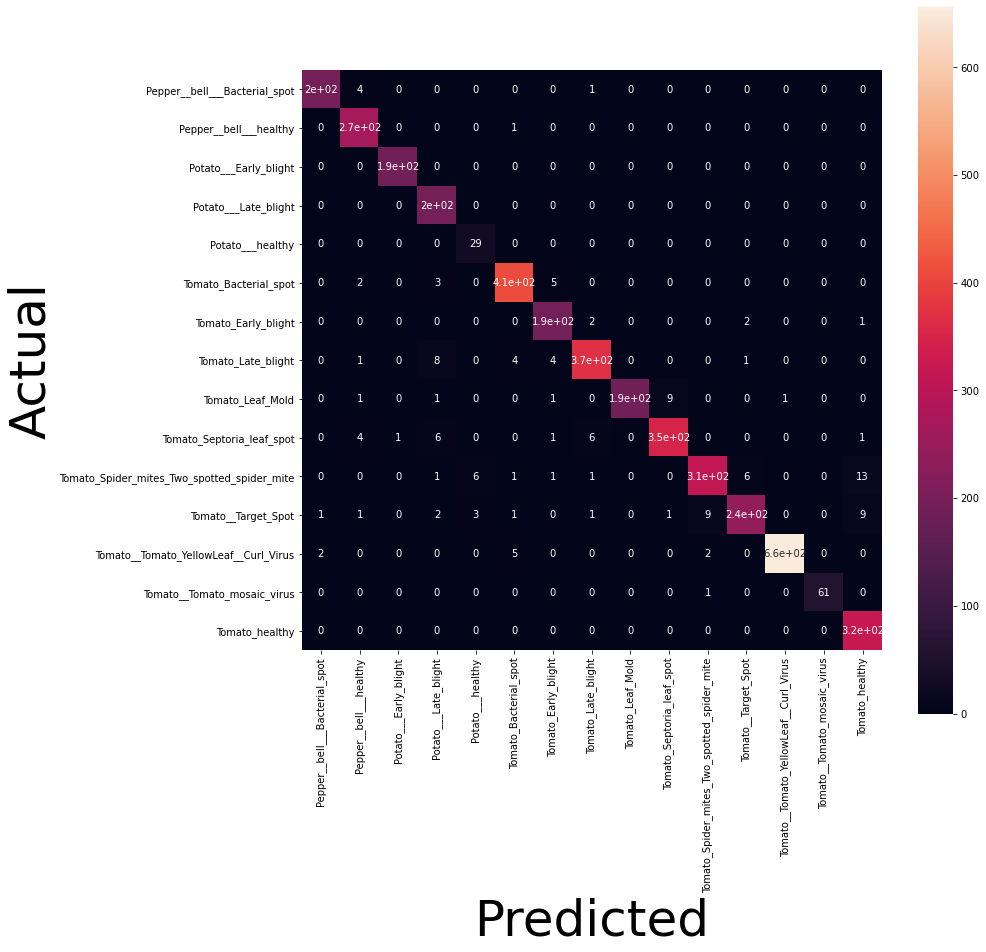

In [14]:
cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(13, 13))
ax = sns.heatmap(cm, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize = 50)
ax.set_xlabel('Predicted', fontsize = 50)